In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/dstl-satellite-imagery-feature-detection/train_wkt_v2.csv
/kaggle/input/dstl-satellite-imagery-feature-detection/train_wkt_v3.csv
/kaggle/input/dstl-satellite-imagery-feature-detection/train_wkt.csv
/kaggle/input/dstl-satellite-imagery-feature-detection/train_wkt_v4.csv
/kaggle/input/dstl-satellite-imagery-feature-detection/grid_sizes.csv
/kaggle/input/dstl-satellite-imagery-feature-detection/sample_submission.csv
/kaggle/input/dstl-satellite-imagery-feature-detection/three_band/6150_1_2.tif
/kaggle/input/dstl-satellite-imagery-feature-detection/three_band/6030_4_3.tif
/kaggle/input/dstl-satellite-imagery-feature-detection/three_band/6160_4_1.tif
/kaggle/input/dstl-satellite-imagery-feature-detection/three_band/6020_3_1.tif
/kaggle/input/dstl-satellite-imagery-feature-detection/three_band/6050_1_2.tif
/kaggle/input/dstl-satellite-imagery-feature-detection/three_band/6080_0_2.tif
/kaggle/input/dstl-satellite-imagery-feature-detection/three_band/6180_3_0.tif
/kaggle/input/d

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
#from sklearn.metrics import jaccard_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import gc
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
N_Cls = 10
inDir = '../input/dstl-satellite-imagery-feature-detection'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
ISZ = 160
smooth = 1e-12

In [4]:
os.mkdir('/kaggle/data/')
os.mkdir('/kaggle/msk/')
os.mkdir('/kaggle/weights/')
os.mkdir('/kaggle/subm/')


In [5]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
   
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

In [6]:
def _get_xmax_ymin(grid_sizes_panda, imageId):
    
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)

In [7]:
def _get_polygon_list(wkt_list_pandas, imageId, cType):
    
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList

In [8]:
def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list

In [9]:
def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask

In [10]:
def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
   
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask

In [11]:
def M(image_id):
    
    filename = os.path.join(inDir, 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img

In [12]:
def stretch_n(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)

In [13]:
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

In [14]:
def jaccard_coef_int(y_true, y_pred):
     # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [15]:
def stick_all_train():
    print ("let's stick all imgs together")
    s = 835

    x = np.zeros((5 * s, 5 * s, 8))
    y = np.zeros((5 * s, 5 * s, N_Cls))

    ids = sorted(DF.ImageId.unique())
    print (len(ids))
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]

            img = M(id)
            img = stretch_n(img)
            print (img.shape, id, np.amax(img), np.amin(img))
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print (np.amax(y), np.amin(y))

    np.save('/kaggle/data/x_trn_%d' % N_Cls, x)
    np.save('/kaggle/data/y_trn_%d' % N_Cls, y)

In [16]:
def get_patches(img, msk, amt=2000, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    x, y = [], []

    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        for j in range(N_Cls):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]

                x.append(im)
                y.append(ms)

    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))
    print (x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y))
    im = None
    ms = None
    xc = None
    yc = None
    del(im,ms,xc,yc)
    gc.collect()
    return x, y

In [17]:
def make_val():
    print ("let's pick some samples for validation")
    img = np.load('/kaggle/data/x_trn_%d.npy' % N_Cls)
    msk = np.load('/kaggle/data/y_trn_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=2000)

    np.save('/kaggle/data/x_tmp_%d' % N_Cls, x)
    np.save('/kaggle/data/y_tmp_%d' % N_Cls, y)
    
    img = None
    msk = None
    x = None
    y = None
    del(img,msk,x,y)
    gc.collect()

In [18]:
def jaccard_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)

In [19]:
def get_unet():
    inputs = Input((8, ISZ, ISZ))
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_first')(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_first')(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_first')(conv3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2),data_format='channels_first')(drop4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(UpSampling2D(size = (2,2),data_format='channels_first')(drop5))
    merge6 = concatenate([drop4,up6], axis = 1)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(UpSampling2D(size = (2,2),data_format='channels_first')(conv6))
    merge7 = concatenate([conv3,up7], axis = 1)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(UpSampling2D(size = (2,2),data_format='channels_first')(conv7))
    merge8 = concatenate([conv2,up8], axis = 1)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(UpSampling2D(size = (2,2),data_format='channels_first')(conv8))
    merge9 = concatenate([conv1,up9], axis = 1)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv9)
    conv10 = Conv2D(N_Cls, (1, 1),strides=1, activation = 'sigmoid',data_format='channels_first')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    #model.compile(optimizer=Adam(lr=1e-4), loss = jaccard_loss, metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

    return model

In [20]:
def calc_jacc(model):
    img = np.load('/kaggle/data/x_tmp_%d.npy' % N_Cls)
    msk = np.load('/kaggle/data/y_tmp_%d.npy' % N_Cls)

    prd = model.predict(img, batch_size=4)
    print (prd.shape, msk.shape)
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr
        #print (i, m, b_tr)
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    
    img = None
    msk = None
    prd = None
    t_msk = None
    t_prd = None
    b_tr = None
    del(img,msk,prd,t_msk,t_prd,b_tr)
    gc.collect()
    
    return score, trs

In [21]:
def mask_for_polygons(polygons, im_size):
   
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    
    int_coords = None
    exteriors = None
    interiors = None
    del(int_coords,exteriors,interiors)
    gc.collect()
    return img_mask

In [22]:
def mask_for_polygons(polygons, im_size):
    
    
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    
    int_coords = None
    exteriors = None
    interiors = None
    del(int_coords,exteriors,interiors)
    gc.collect()
    return img_mask

In [23]:
def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

In [24]:
def train_net():
    print ("start train net")
    x_val, y_val = np.load('/kaggle/data/x_tmp_%d.npy' % N_Cls), np.load('/kaggle/data/y_tmp_%d.npy' % N_Cls)
    img = np.load('/kaggle/data/x_trn_%d.npy' % N_Cls)
    msk = np.load('/kaggle/data/y_trn_%d.npy' % N_Cls)

    x_trn, y_trn = get_patches(img, msk)

    model = get_unet()
    #model.load_weights('../input/trained-weight/unet_10_jk0.7565')
    model_checkpoint = ModelCheckpoint('unet_tmp.hdf5', monitor='loss', save_best_only=True)
    for i in range(1):
        model.fit(x_trn, y_trn, batch_size=64, epochs=5, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))
        del x_trn
        del y_trn
        #x_trn, y_trn = get_patches(img, msk)
        score, trs = calc_jacc(model)
        print ('val jk'+ str(score))
        model.save_weights('unet_10_jk%.4f' % score)
    
    x_val = None
    y_val = None
    x_trn = None
    y_trn = None
    del(x_val,y_val,x_trn,y_trn)
    gc.collect()
    
    return model, score, trs

In [25]:
def predict_id(id, model, trs):
    img = M(id)
    x = stretch_n(img)

    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]

In [26]:
def predict_test(model, trs):
    print ("predict test")
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save('/kaggle/msk/10_%s' % id, msk)
        #if i % 100 == 0: print (i, id)

In [27]:
def make_submit():
    print ("make submission file")
    df = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
    print (df.head())
    for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1

        msk = np.load('/kaggle/msk/10_%s.npy' % id)[kls]
        pred_polygons = mask_to_polygons(msk)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 1000 == 0: print (idx)
    print (df.head())
    df.to_csv('/kaggle/subm/1.csv', index=False)

In [28]:
def check_predict(id='6120_2_3'):
    model = get_unet()
    model.load_weights('/kaggle/working/unet_10_jk%.4f' % score)

    msk = predict_id(id, model, [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    m = M(id)
    print(m.shape)
    class_list = ["Buildings", "Misc.Manmade structures" ,"Road",\
                  "Track","Trees","Crops","Waterway","Standing water",\
                  "Vehicle Large","Vehicle Small"]
    
    img = np.zeros((m.shape[0],m.shape[1],3))
    img[:,:,0] = m[:,:,4] #red
    img[:,:,1] = m[:,:,2] #green
    img[:,:,2] = m[:,:,1] #blue
    for i in range(10):
        plt.figure(figsize=(20,20))
        ax1 = plt.subplot(131)
        ax1.set_title('image ID:6120_2_3')
        ax1.imshow(stretch_n(img))
        ax2 = plt.subplot(132)
        ax2.set_title("predict "+ class_list[i] +" pixels")
        ax2.imshow(msk[i], cmap=plt.get_cmap('gray'))
        ax3 = plt.subplot(133)
        ax3.set_title("predict " + class_list[i] + " polygones")
        ax3.imshow(mask_for_polygons(mask_to_polygons(msk[i], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))
        plt.show()

In [29]:
stick_all_train()
DF = None
x = None
y = None
img = None
ids = None
del(DF,x,y,img,ids)
gc.collect()

let's stick all imgs together
25
(837, 849, 8) 6010_1_2 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0
(837, 848, 8) 6010_4_4 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(838, 835, 8) 6070_2_3 1.0 0.0
(837, 848, 8) 6090_2_0 1.0 0.0
(837, 848, 8) 6100_1_3 1.0 0.0
(837, 848, 8) 6100_2_2 1.0 0.0
(837, 848, 8) 6100_2_3 1.0 0.0
(837, 849, 8) 6110_1_2 1.0 0.0
(837, 849, 8) 6110_3_1 1.0 0.0
(837, 849, 8) 6110_4_0 1.0 0.0
(837, 851, 8) 6120_2_0 1.0 0.0
(837, 851, 8) 6120_2_2 1.0 0.0
(837, 849, 8) 6140_1_2 1.0 0.0
(837, 849, 8) 6140_3_1 1.0 0.0
(837, 851, 8) 6150_2_3 1.0 0.0
(837, 848, 8) 6160_2_1 1.0 0.0
(837, 848, 8) 6170_0_4 1.0 0.0
(837, 848, 8) 6170_2_4 1.0 0.0
(837, 848, 8) 6170_4_1 1.0 0.0
1.0 0.0


86

In [30]:
make_val()


let's pick some samples for validation
(687, 8, 160, 160) (687, 10, 160, 160) 1.0 -1.0 1.0 0.0


In [31]:
model, score, trs = train_net()


start train net
(742, 8, 160, 160) (742, 10, 160, 160) 1.0 -1.0 1.0 0.0
Train on 742 samples, validate on 687 samples
Epoch 1/5
742/742 [==============================] - 596s 804ms/step - loss: 0.7323 - jaccard_coef: 0.0579 - jaccard_coef_int: 0.0433 - accuracy: 0.5347 - val_loss: 0.6324 - val_jaccard_coef: 0.0579 - val_jaccard_coef_int: 0.0404 - val_accuracy: 0.6087
Epoch 2/5
742/742 [==============================] - 592s 799ms/step - loss: 0.4529 - jaccard_coef: 0.0456 - jaccard_coef_int: 0.0216 - accuracy: 0.7715 - val_loss: 0.3339 - val_jaccard_coef: 0.0509 - val_jaccard_coef_int: 0.0203 - val_accuracy: 0.8835
Epoch 3/5
742/742 [==============================] - 591s 797ms/step - loss: 0.2536 - jaccard_coef: 0.0437 - jaccard_coef_int: 0.0200 - accuracy: 0.9048 - val_loss: 0.2728 - val_jaccard_coef: 0.0514 - val_jaccard_coef_int: 0.0146 - val_accuracy: 0.9124
Epoch 4/5
742/742 [==============================] - 591s 796ms/step - loss: 0.2172 - jaccard_coef: 0.0460 - jaccard_coef_i

In [32]:
def mask_to_polygons(mask, epsilon=5, min_area=1.):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    contours, hierarchy = cv2.findContours(((mask == 1) * 255).astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

(837, 851, 8)


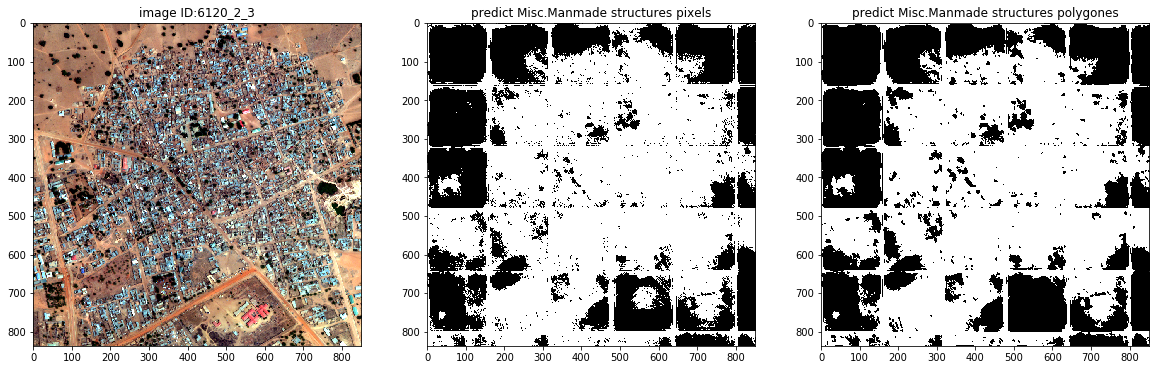

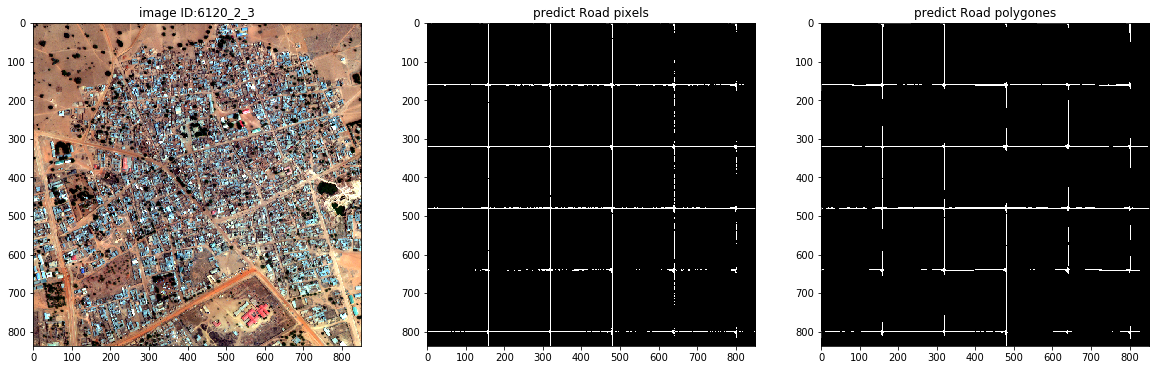

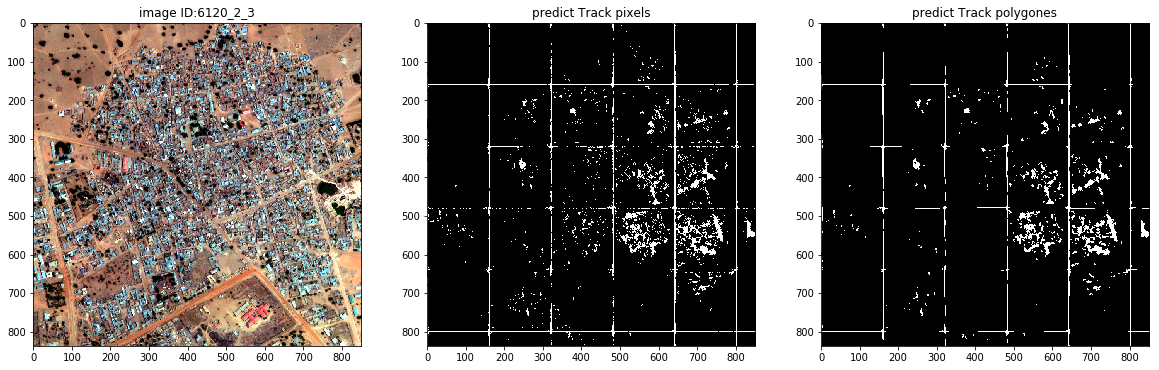

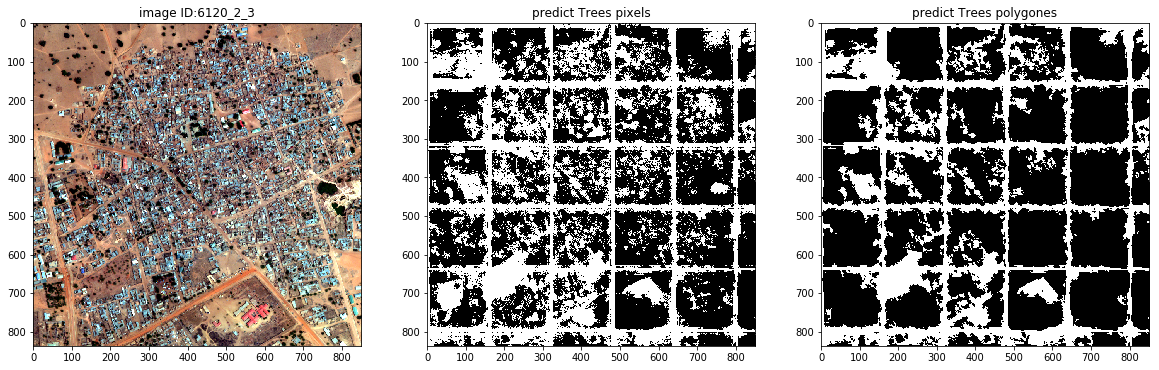

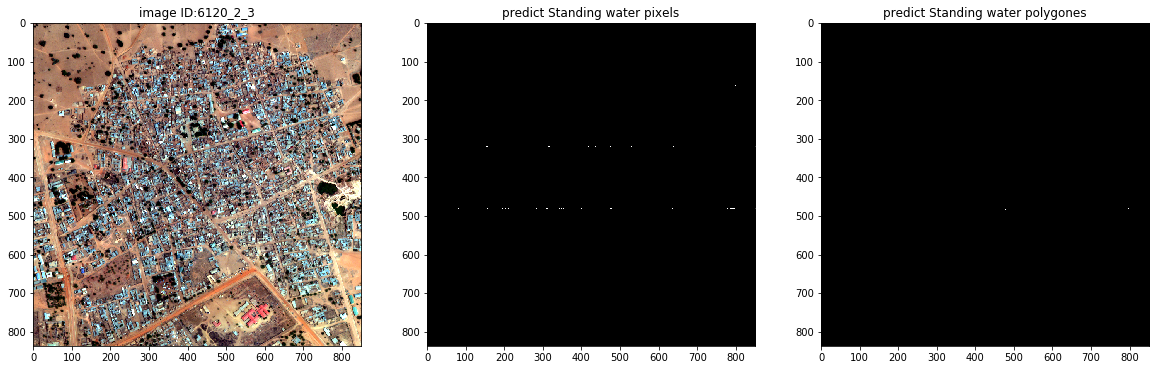

In [33]:
check_predict('6120_2_2')

In [34]:
score

0.7195459280400474